## Imports


In [5]:
import os
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm

from bergson.data import load_gradients
from safetensors.torch import load_file

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import json

## Paths + Helper function



In [6]:
# merged medical

index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_medical/merged_medical"
# ekfac_query_path = (
#     "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query95a3930f07f9889712dc2a3e565000f1"
# )


query_data_path_csv = (
    "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/merged_medical_llama.csv"
)

In [7]:
# # merged code

# index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_code/merged_code"
# # ekfac_query_path = (
# #     "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/queryfa2c3e9d26bc41cf6a9bf1b45f43b9db"
# # )

# ekfac_query_path = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query07e71a09354a6b9e89561ff6bec946ac"  # using eval for ekfac
# query_path = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query_proj16"


# query_data_path_csv = (
#     "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/merged_code_completions.csv"
# )

In [8]:
query_ekfac_eval = (
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query_55062c362f3a1ffe20016662f3ca5f0c"
)
query_ekfac_train = (
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query_d8ab5e0b71ab9fc4f54f58e6e4941898"
)
query_raw = "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical_cache/query_proj16"
query_ekfac_with_attn_eval = (
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query_253b5a8f9e5918aa3acfe7aedaaa4842"
)
query_ekfac_with_attn_train = (
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_medical/query_be8b5324283cf3e71560d50453797a25"
)

In [9]:
def compute_attribution(query_path, index_path, query_data_path_csv, unit_norm=True):
    df_alignment_scores = pd.read_csv(query_data_path_csv)
    index = load_gradients(index_path)
    queries = load_gradients(query_path)

    names_index = index.dtype.names
    names_queries = queries.dtype.names

    names_intersection = list(set(names_index).intersection(set(names_queries)))

    index_tensor = torch.cat(
        [torch.from_numpy(index[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1
    )  # ( num_index, dim)

    query_tensor = torch.cat(
        [torch.from_numpy(queries[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1
    )  # ( num_query, dim)

    if unit_norm:
        index_tensor = index_tensor / index_tensor.norm(dim=1, keepdim=True)
        query_tensor = query_tensor / query_tensor.norm(dim=1, keepdim=True)

    attributions = torch.einsum("qd,id->iq", query_tensor, index_tensor).cpu().numpy()

    average_question_alignment = df_alignment_scores.groupby("question_id")["aligned"].mean()

    df_alignment_scores["advantage"] = (
        df_alignment_scores["question_id"].map(average_question_alignment) - df_alignment_scores["aligned"]
    )

    attributions_scores = np.nanmean(attributions * df_alignment_scores["advantage"].values, axis=1)

    return attributions_scores

In [10]:
def spearman_correlation_plot(scores1, scores2, label1="Scores 1", label2="Scores 2", figsize=(10, 8), title=None):
    """
    Calculate Spearman correlation between two score arrays and create a scatter plot.

    Args:
        scores1 (array-like): First set of scores
        scores2 (array-like): Second set of scores
        label1 (str): Label for first scores (x-axis)
        label2 (str): Label for second scores (y-axis)
        figsize (tuple): Figure size for the plot

    Returns:
        tuple: (spearman_correlation, p_value)
    """

    # Convert to numpy arrays if needed
    scores1 = np.array(scores1)
    scores2 = np.array(scores2)

    # Remove NaN values
    mask = ~(np.isnan(scores1) | np.isnan(scores2))
    clean_scores1 = scores1[mask]
    clean_scores2 = scores2[mask]

    if len(clean_scores1) == 0:
        print("Error: No valid data points after removing NaN values")
        return None, None

    # Calculate Spearman correlation
    spearman_corr, p_value = spearmanr(clean_scores1, clean_scores2)

    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"P-value: {p_value:.2e}")
    print(f"Number of valid pairs: {len(clean_scores1)}")

    # Create scatter plot
    plt.figure(figsize=figsize)
    plt.scatter(clean_scores1, clean_scores2, alpha=0.6, s=30)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title(f"Spearman Correlation {title}: ρ = {spearman_corr:.4f}, p = {p_value:.2e}")
    plt.grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(clean_scores1, clean_scores2, 1)
    trend_line = np.poly1d(z)
    plt.plot(clean_scores1, trend_line(clean_scores1), "r--", alpha=0.8, linewidth=2, label="Trend line")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return spearman_corr, p_value


# Usage examples:
# corr, p_val = spearman_correlation_plot(attributions_scores, attributions_ekfac_scores)
#
# # With custom labels:
# corr, p_val = spearman_correlation_plot(
#     attributions_scores,
#     attributions_ekfac_scores,
#     label1="Attribution Scores",
#     label2="Attribution EKFAC Scores"
# )

## Compare two query types

In [9]:
# load csv
df_alignment_scores = pd.read_csv(query_data_path_csv)
index = load_gradients(index_path)

In [11]:
queries = load_gradients(query_path)

queries_ekfac = load_gradients(query_ekfac_with_attn_eval)

In [13]:
names_index = index.dtype.names
names_queries = queries.dtype.names
names_queries_ekfac = queries_ekfac.dtype.names

names_intersection = list(set(names_index).intersection(set(names_queries)))
names_intersection_ekfac = list(set(names_index).intersection(set(names_queries_ekfac)))


In [14]:
# names_intersection = [n for n in names_intersection if "attn" not in n]
# names_intersection_ekfac = [n for n in names_intersection_ekfac if "attn" not in n]

In [15]:
unit_norm = True


index_tensor = torch.cat(
    [torch.from_numpy(index[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1
)  # ( num_index, dim)

index_tensor_ekfac = torch.cat(
    [torch.from_numpy(index[name]).to("cuda", dtype=torch.float32) for name in names_intersection_ekfac], dim=1
)

query_tensor = torch.cat(
    [torch.from_numpy(queries[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1
)  # ( num_query, dim)

query_tensor_ekfac = torch.cat(
    [torch.from_numpy(queries_ekfac[name]).to("cuda", dtype=torch.float32) for name in names_intersection_ekfac], dim=1
)  # ( num_query, dim)

if unit_norm:
    index_tensor = index_tensor / index_tensor.norm(dim=1, keepdim=True)
    query_tensor = query_tensor / query_tensor.norm(dim=1, keepdim=True)
    query_tensor_ekfac = query_tensor_ekfac / query_tensor_ekfac.norm(dim=1, keepdim=True)


attributions = torch.einsum("qd,id->iq", query_tensor, index_tensor)
attributions_ekfac = torch.einsum("qd,id->iq", query_tensor_ekfac, index_tensor_ekfac)

/tmp/ipykernel_760914/2000273760.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  [torch.from_numpy(index[name]).to("cuda", dtype=torch.float32) for name in names_intersection], dim=1


In [16]:
attributions_ekfac = attributions_ekfac.cpu().numpy()
attributions = attributions.cpu().numpy()

In [17]:
average_question_alignment = df_alignment_scores.groupby("question_id")["aligned"].mean()

df_alignment_scores["advantage"] = (
    df_alignment_scores["question_id"].map(average_question_alignment) - df_alignment_scores["aligned"]
)


In [18]:
attributions_scores = np.nanmean(attributions * df_alignment_scores["advantage"].values, axis=1)
attributions_ekfac_scores = np.nanmean(attributions_ekfac * df_alignment_scores["advantage"].values, axis=1)

Spearman Correlation: 0.8247
P-value: 0.00e+00


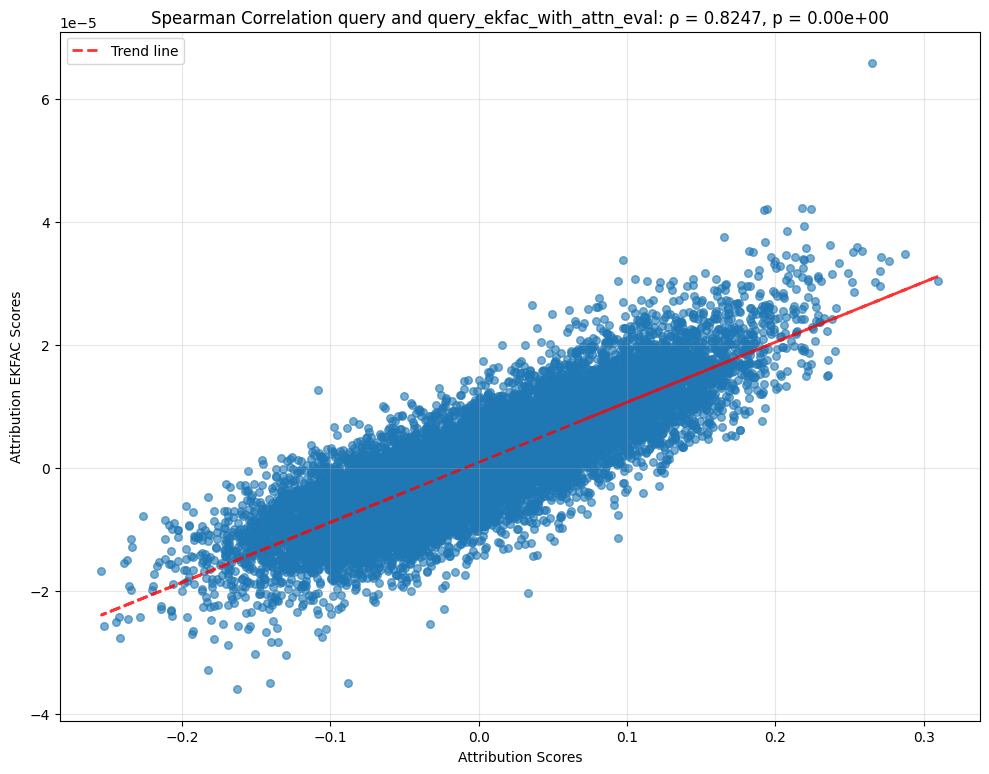

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Calculate Spearman correlation
mask = ~(np.isnan(attributions_scores) | np.isnan(attributions_ekfac_scores))
clean_scores1 = attributions_scores[mask]
clean_scores2 = attributions_ekfac_scores[mask]

spearman_corr, p_value = spearmanr(clean_scores1, clean_scores2)

print(f"Spearman Correlation: {spearman_corr:.4f}")
print(f"P-value: {p_value:.2e}")

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(clean_scores1, clean_scores2, alpha=0.6, s=30)
plt.xlabel("Attribution Scores")
plt.ylabel("Attribution EKFAC Scores")
plt.title(f"Spearman Correlation query and query_ekfac_with_attn_eval: ρ = {spearman_corr:.4f}, p = {p_value:.2e}")
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(clean_scores1, clean_scores2, 1)
p = np.poly1d(z)
plt.plot(clean_scores1, p(clean_scores1), "r--", alpha=0.8, linewidth=2, label="Trend line")
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
top_percentages = [0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 0.99, 0.999]

intersections = []
intersections_ekfac = []

intersections_random = []

for perc in top_percentages:
    # top x percent indices

    top_k = int(perc * len(index))  # top 10%
    # _, top_indices = torch.topk(attribution_query, top_k) # mean over all components
    top_indices = np.argpartition(attributions_scores, -top_k)[-top_k:]
    top_indices_ekfac = np.argpartition(attributions_ekfac_scores, -top_k)[-top_k:]

    intersection_ekfac = (top_indices_ekfac < (len(index) // 2)).sum()
    intersection = (top_indices < (len(index) // 2)).sum()
    intersections.append(intersection.item())
    intersections_ekfac.append(intersection_ekfac.item())

    # random baseline
    random_indices = torch.randperm(len(index))[:top_k]
    intersection_random = (random_indices < (len(index) // 2)).sum()
    intersections_random.append(intersection_random.item())


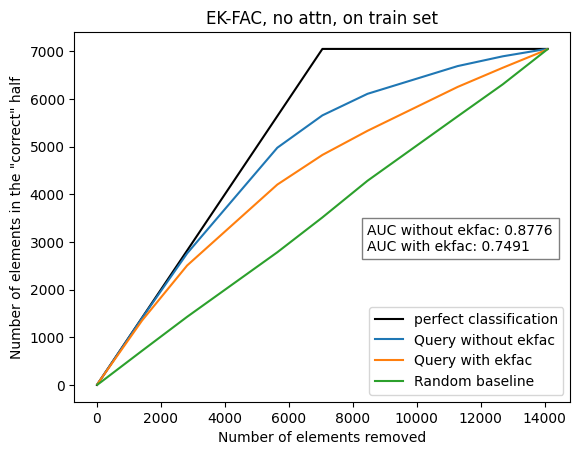

In [33]:
plt.plot(
    [0, len(index) // 2, len(index)],
    [0, len(index) // 2, len(index) // 2],
    label="perfect classification",
    color="black",
)


plt.plot(np.array(top_percentages) * len(index), intersections, label=f"Query without ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_ekfac, label=f"Query with ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_random, label=f"Random baseline")
plt.xlabel("Number of elements removed")
plt.ylabel('Number of elements in the "correct" half')
plt.title("EK-FAC, no attn, on train set")


plt.legend()


# add auc to the plot
from sklearn.metrics import roc_auc_score

y_true = np.array([1] * (len(index) // 2) + [0] * (len(index) // 2))
roc_auc = roc_auc_score(y_true, attributions_scores)
roc_auc_ekfac = roc_auc_score(y_true, attributions_ekfac_scores)
plt.text(
    len(index) * 0.6,
    len(index) * 0.2,
    f"AUC without ekfac: {roc_auc:.4f}\nAUC with ekfac: {roc_auc_ekfac:.4f}",
    bbox=dict(facecolor="white", alpha=0.5),
)

plt.show()

In [32]:
from sklearn.metrics import roc_auc_score

y_true = np.array([1] * (len(index) // 2) + [0] * (len(index) // 2))
roc_auc = roc_auc_score(y_true, attributions_scores)
roc_auc_ekfac = roc_auc_score(y_true, attributions_ekfac_scores)
print(f"ROC AUC without ekfac: {roc_auc}")
print(f"ROC AUC with ekfac: {roc_auc_ekfac}")

ROC AUC without ekfac: 0.8776147978680175
ROC AUC with ekfac: 0.749104806169955


## Computing attribution tensors

In [2]:
# # merged_medical
# all_query_paths = [
#     query_ekfac_with_attn_eval,
#     query_ekfac_with_attn_train,
#     query_raw,
#     query_ekfac_eval,
#     query_ekfac_train,
# ]

In [7]:
# # bad_financial
# all_query_paths = [
#     "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/bad_financial/query_2e1ef384b013061f04ed0e8c826e4f82"
# ]

# index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_financial/financial"
# query_data_path_csv = "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/financial.csv"

In [12]:
# # mixed_math
# all_query_paths = [
#     "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/mixed_math/query_13c0ee8eadd63dc4da2dcc5e638dd5ba"
# ]

# index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_math/math"
# query_data_path_csv = "/mnt/ssd-1/louis/finetuned_em_models/openai_filtered_models/evals/math_filtered_1500_3500.csv"

In [9]:
# # science
# all_query_paths = [
#     "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/mixed_science/query_5e2108a8ee7c8514c53248b86c5089e8"
# ]

# index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_science/science"
# query_data_path_csv = "/mnt/ssd-1/louis/finetuned_em_models/openai_filtered_models/evals/science_filtered_1000_2500.csv"

In [20]:
# merged_code
all_query_paths = [
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query_e70671073ccd5aa2759f107687cf6ca0",
    "/mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query_16",
]

index_path = "/mnt/ssd-1/gpaulo/emergent-misalignment/qwen14_merged_code/merged_code"
query_data_path_csv = (
    "/mnt/ssd-1/gpaulo/emergent-misalignment/emergent-misalignment-eleuther/open_models/merged_code_completions.csv"
)

In [22]:
for path in all_query_paths:
    print(f"Computing attributions for {path}")
    attributions_scores = compute_attribution(path, index_path, query_data_path_csv, unit_norm=True)
    # save to a file
    config_path = path + "/config.json"
    config = json.load(open(config_path))
    key = os.path.basename(config["ekfac_path"])
    # path_final = os.path.basename(path)
    path_final = f"query_{key}"

    np.save(path_final + "_attributions_scores.npy", attributions_scores)
    print(f"Saved to {path_final}_attributions_scores.npy")

Computing attributions for /mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query_e70671073ccd5aa2759f107687cf6ca0
Saved to query_ekfac_merged_code_eval_with_attn_attributions_scores.npy
Computing attributions for /mnt/ssd-1/louis/emergent_misalignment/gradients_data/merged_code/query_16
Saved to query_None_attributions_scores.npy


In [23]:
# load the saved attributions
import json


all_attributions = {}

for path in all_query_paths:
    config_path = path + "/config.json"
    config = json.load(open(config_path))
    key = os.path.basename(config["ekfac_path"])

    path_final = f"query_{key}"
    attributions_scores = np.load(path_final + "_attributions_scores.npy")

    all_attributions[key] = attributions_scores

In [24]:
index = load_gradients(index_path)


In [25]:
intersections_dict = {}

top_percentages = [0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 0.99, 0.999]

for key, attributions in all_attributions.items():
    intersections = []
    for perc in top_percentages:
        top_k = int(perc * len(index))
        top_indices = np.argpartition(attributions, -top_k)[-top_k:]
        intersection = (top_indices < (len(index) // 2)).sum()
        intersections.append(intersection.item())
    intersections_dict[key] = intersections

# add random baseline
intersections_random = []
for perc in top_percentages:
    top_k = int(perc * len(index))
    random_indices = torch.randperm(len(index))[:top_k]
    intersection_random = (random_indices < (len(index) // 2)).sum()
    intersections_random.append(intersection_random.item())
intersections_dict["random"] = intersections_random


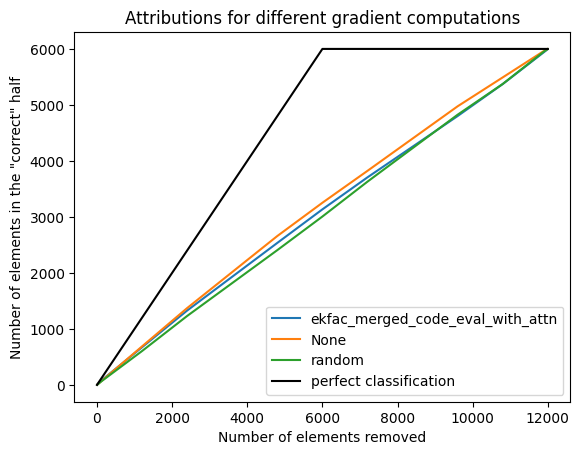

In [26]:
# plot all the intersections
for key, intersections in intersections_dict.items():
    plt.plot(np.array(top_percentages) * len(index), intersections, label=key)
plt.plot(
    [0, len(index) // 2, len(index)],
    [0, len(index) // 2, len(index) // 2],
    label="perfect classification",
    color="black",
)
plt.xlabel("Number of elements removed")
plt.ylabel('Number of elements in the "correct" half')
plt.title("Attributions for different gradient computations")
plt.legend()
plt.show()


In [27]:
all_attributions.keys()

dict_keys(['ekfac_merged_code_eval_with_attn', 'None'])

In [28]:
# auc

from sklearn.metrics import roc_auc_score

for key, attributions in all_attributions.items():
    y_true = np.array([1] * (len(index) // 2) + [0] * (len(index) // 2))
    roc_auc = roc_auc_score(y_true, attributions)
    print(f"ROC AUC for {key}: {roc_auc}")

ROC AUC for ekfac_merged_code_eval_with_attn: 0.5244284166666667
ROC AUC for None: 0.5563616111111112


In [29]:
label1 = "ekfac_merged_medical_train_with_attn"
label2 = "ekfac_merged_medical_eval_with_attn"

spearman_correlation_plot(
    all_attributions[label1],
    all_attributions[label2],
    label1=label1,
    label2=label2,
    title=label1 + " vs " + label2,
)

KeyError: 'ekfac_merged_medical_train_with_attn'

In [13]:
attributions_1 = all_attributions["no_ekfac"]
attributions_2 = all_attributions["ekfac_merged_medical_eval_with_attn"]
intersection_12 = []

for perc in top_percentages:
    top_k = int(perc * len(index))
    top_indicies_1 = np.argpartition(attributions_1, -top_k)[-top_k:]

    top_indicies_2 = np.argpartition(attributions_2, -top_k)[-top_k:]

    intersection = len(set(top_indicies_1).intersection(set(top_indicies_2)))
    intersection_12.append(intersection)


KeyError: 'no_ekfac'

In [16]:
# plot intersection
plt.plot(np.array(top_percentages) * len(index), intersection_12, label=f"Intersection")
plt.plot(
    [0, len(index) // 2, len(index)],
    [0, len(index) // 2, len(index)],
    label="perfect agreement",
    color="black",
)
plt.xlabel("Topk elements")
plt.ylabel("Number of elements in the intersection")
plt.title("Intersection between no ekfac and ekfac_eval_with_attn")
plt.legend()
plt.show()

NameError: name 'intersection_12' is not defined

## Compute new attributions

In [89]:
attribution_query = torch.zeros((len(index)), device="cuda")
attribution_ekfac_query = torch.zeros((len(index)), device="cuda")

In [120]:
attribution_query = torch.zeros((len(index)), device="cuda")
attribution_ekfac_query = torch.zeros((len(index)), device="cuda")
dict_of_attributions_ekfac = {}
dict_of_attributions = {}
normalize = True
for name in names:
    index_tensor = torch.from_numpy(index[name]).to("cuda", dtype=torch.float32)  # ( num_index, dim)
    query_tensor_ekfac = torch.from_numpy(queries_ekfac[name]).to("cuda")  # ( num_query, dim)
    query_tensor = torch.from_numpy(queries[name]).to("cuda", dtype=torch.float32)  # ( num_query, dim)

    if normalize:
        index_tensor = index_tensor / (index_tensor.norm(dim=-1, keepdim=True) + 1e-10)
        query_tensor_ekfac = query_tensor_ekfac / (query_tensor_ekfac.norm(dim=-1, keepdim=True) + 1e-10)
        query_tensor = query_tensor / (query_tensor.norm(dim=-1, keepdim=True) + 1e-10)

    dot_product_ekfac = torch.einsum("qd,id->qi", query_tensor_ekfac, index_tensor)  # (num_query, num_index)
    dot_product = torch.einsum("qd,id->qi", query_tensor, index_tensor)  # (num_query, num_index)

    # weight by advantages
    weighted_dot_ekfac = torch.einsum("qi,q->qi", dot_product_ekfac, -final_advantages)  # (num_query, num_index)
    weighted_dot = torch.einsum("qi,q->qi", dot_product, -final_advantages)  # (num_query, num_index)

    dict_of_attributions_ekfac[name] = weighted_dot_ekfac.sum(dim=0)
    dict_of_attributions[name] = weighted_dot.sum(dim=0)

    # sum over queries
    attribution_ekfac_query += weighted_dot_ekfac.sum(dim=0)  # (num_index,)
    attribution_query += weighted_dot.sum(dim=0)  # (num_index,)


In [121]:
from sklearn.metrics import roc_auc_score

auc_scores_ekfac = []
auc_scores = []

for name in names:
    auc = roc_auc_score([1] * (len(index) // 2) + [0] * (len(index) // 2), dict_of_attributions[name].cpu().numpy())
    auc_ekfac = roc_auc_score(
        [1] * (len(index) // 2) + [0] * (len(index) // 2), dict_of_attributions_ekfac[name].cpu().numpy()
    )
    auc_scores.append(auc)
    auc_scores_ekfac.append(auc_ekfac)


In [122]:
auc_scores = torch.tensor(auc_scores)
auc_scores_ekfac = torch.tensor(auc_scores_ekfac)


In [129]:
topk_auc = []
topk_auc_ekfac = []
for k in range(1, len(names)):
    topk_indices = torch.topk(auc_scores, k=k).indices
    topk_indices_ekfac = torch.topk(auc_scores_ekfac, k=k).indices

    list_of_attributions = list(dict_of_attributions.values())
    list_of_attributions_ekfac = list(dict_of_attributions_ekfac.values())

    final_attribution = torch.stack([list_of_attributions[i] for i in topk_indices], dim=0)
    final_attribution_ekfac = torch.stack([list_of_attributions_ekfac[i] for i in topk_indices_ekfac], dim=0)

    mean_final_attribution = final_attribution.mean(dim=0)
    mean_final_attribution_ekfac = final_attribution_ekfac.mean(dim=0)

    final_attribution_auc = roc_auc_score(
        [1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution.cpu().numpy()
    )
    final_attribution_ekfac_auc = roc_auc_score(
        [1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution_ekfac.cpu().numpy()
    )

    topk_auc.append(final_attribution_auc)
    topk_auc_ekfac.append(final_attribution_ekfac_auc)

    if k == 50:
        break


In [130]:
topk_indices_ekfac

tensor([216, 264, 200, 127, 132, 243, 169,   2, 256, 188, 181, 174,  54, 242,
        113,  90, 235,  59, 125,  96,  88, 101, 155, 117, 240, 203, 106,  42,
         44, 197, 259, 226, 198, 140, 164, 146, 211,  77, 176,  87, 279, 130,
        168, 265,  80, 160,  79, 258,  98, 119])

In [131]:
topk_indices

tensor([118, 264, 106, 258, 122,  90, 281, 130, 224, 108, 220, 116,  28, 124,
        162, 114,  38, 226, 120, 241, 128, 100, 126, 225, 157, 204,   3,  79,
        155, 110, 132,  35, 255,  50,  45, 102, 254, 185, 159,  63, 247,  18,
         55, 208, 242,  34, 109, 131, 117,  19])

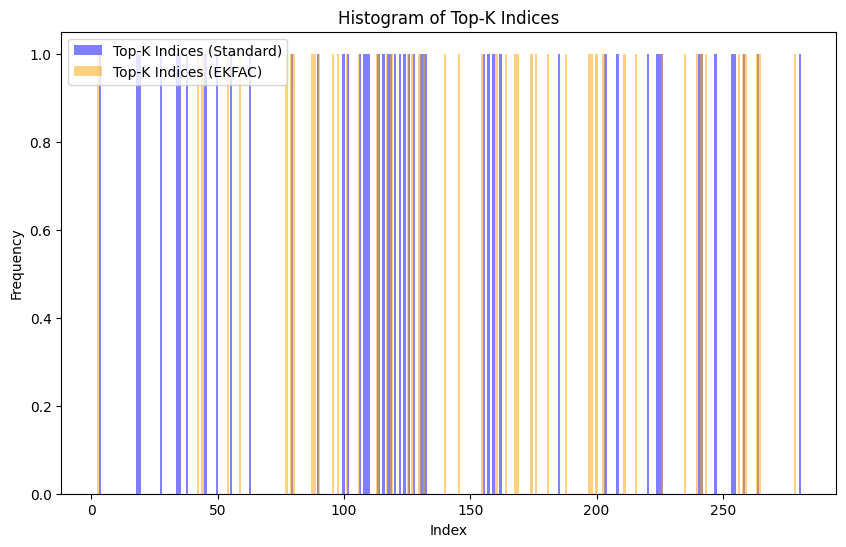

In [138]:
# Turn the top-k indices into histograms
plt.figure(figsize=(10, 6))
plt.hist(topk_indices.cpu().numpy(), bins=300, alpha=0.5, label="Top-K Indices (Standard)", color="blue")
plt.hist(topk_indices_ekfac.cpu().numpy(), bins=300, alpha=0.5, label="Top-K Indices (EKFAC)", color="orange")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.title("Histogram of Top-K Indices")
plt.legend()
plt.show()

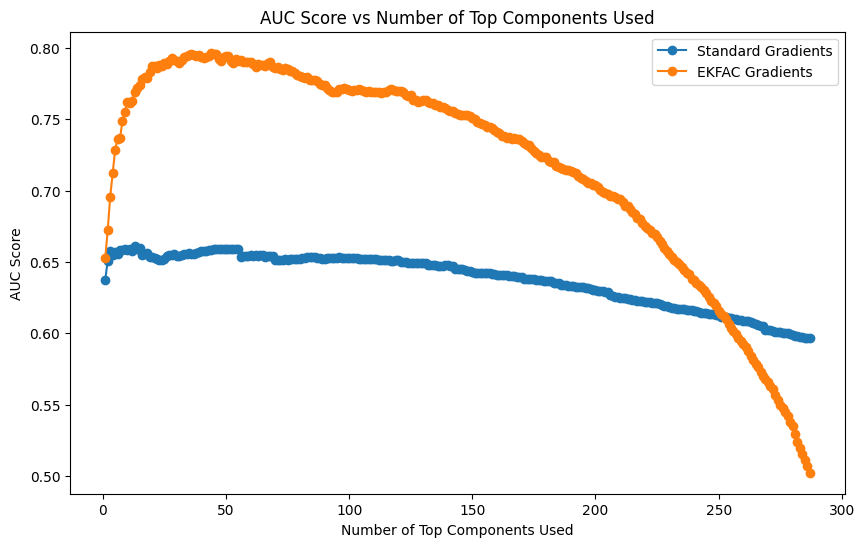

In [124]:
# plot tok_auc and topk_auc_ekfac
plt.figure(figsize=(10, 6))
plt.plot(range(1, k + 1), topk_auc, label="Standard Gradients", marker="o")
plt.plot(range(1, k + 1), topk_auc_ekfac, label="EKFAC Gradients", marker="o")
plt.xlabel("Number of Top Components Used")
plt.ylabel("AUC Score")
plt.title("AUC Score vs Number of Top Components Used")
plt.legend()
plt.show()

In [125]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score([1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution.cpu().numpy())
auc

0.5963884722222224

In [126]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score([1] * (len(index) // 2) + [0] * (len(index) // 2), mean_final_attribution_ekfac.cpu().numpy())
auc


0.5021828333333334

In [86]:
top_percentages = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]  # how much to filter

intersections = []
intersections_ekfac = []

intersections_random = []

for perc in top_percentages:
    # top x percent indices

    top_k = int(perc * len(index))  # top 10%
    # _, top_indices = torch.topk(attribution_query, top_k) # mean over all components
    _, top_indices = torch.topk(mean_final_attribution, top_k)  # top k components

    # top x percent indices

    top_k = int(perc * len(index))  # top 10%
    # _, top_indices_ekfac = torch.topk(attribution_ekfac_query, top_k)
    _, top_indices_ekfac = torch.topk(mean_final_attribution_ekfac, top_k)

    intersection_ekfac = (top_indices_ekfac < (len(index) // 2)).sum()
    intersection = (top_indices < (len(index) // 2)).sum()
    intersections.append(intersection.item())
    intersections_ekfac.append(intersection_ekfac.item())

    # random baseline
    random_indices = torch.randperm(len(index))[:top_k]
    intersection_random = (random_indices < (len(index) // 2)).sum()
    intersections_random.append(intersection_random.item())


NameError: name 'mean_final_attribution' is not defined

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

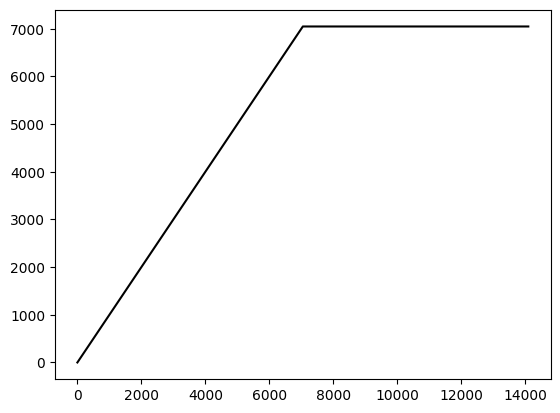

In [85]:
plt.plot(
    [0, len(index) // 2, len(index)],
    [0, len(index) // 2, len(index) // 2],
    label="perfect classification",
    color="black",
)


plt.plot(np.array(top_percentages) * len(index), intersections, label=f"Query without ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_ekfac, label=f"Query with ekfac")
plt.plot(np.array(top_percentages) * len(index), intersections_random, label=f"Random baseline")
plt.xlabel("Number of elements removed")
plt.ylabel('Number of elements in the "correct" half')
plt.legend()
plt.show()

## inspect EV correction

In [2]:
path = "/mnt/ssd-1/louis/emergent_misalignment/ekfac/ekfac_mixed_math_eval_with_attn/influence_results/eigenvalue_correction_sharded"

In [14]:
subpaths = [os.path.join(path, f) for f in os.listdir(path)]
# sort
subpaths = sorted(subpaths)

In [16]:
tensor_dicts = [load_file(subpath) for subpath in subpaths]

In [41]:
names = list(tensor_dicts[0].keys())

In [42]:
full_tensor_dict = {}
for name in names:
    tensors = [tensor_dict[name] for tensor_dict in tensor_dicts]
    full_tensor = torch.cat(tensors, dim=0)
    # mean and variance
    full_tensor_dict[name] = full_tensor


In [47]:
names[1]

'model.model.layers.0.mlp.down_proj.lora_B.default'

In [56]:
for name in names:
    x = full_tensor_dict[name].flatten().to(dtype=torch.float32)
    x = x.sort().values

    # plot x
    plt.figure(figsize=(10, 6))
    plt.plot(x.cpu().numpy())
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue")
    # logscale
    plt.yscale("log")
    plt.title(f"Eigenvalues {name}")

    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/eigenvalues_ekfac_mixed_math_eval_with_attn_{name}.png")
    plt.close()


In [9]:
import torch
import os

# Set the debug flag - this is the correct way
os.environ["TORCH_COMPILE_DEBUG"] = "1"


def eigen_correction(a, g):
    temp = torch.einsum("NSI,NSO->NOI", a, g)
    return (temp**2).sum(dim=0)


# Test tensors
N, S, I, O = 4, 8, 64, 32
a = torch.randn(N, S, I, device="cuda")
g = torch.randn(N, S, O, device="cuda")

print("Compiling and running function...")
compiled_fn = torch.compile(eigen_correction, backend="inductor")
result = compiled_fn(a, g)

print("\nLook for the debug output above ^^^ and also check the debug directory that will be printed")
print("The generated Triton/CUDA code will be in the 'output_code.py' files in those debug directories")


Compiling and running function...


W0919 10:31:08.877000 2868546 torch/_inductor/debug.py:454] [3/0] model__8_inference_0 debug trace: /root/bergson/bergson/hessians/torch_compile_debug/run_2025_09_19_10_31_08_092347-pid_2868546/torchinductor/model__8_inference_0.0



Look for the debug output above ^^^ and also check the debug directory that will be printed
The generated Triton/CUDA code will be in the 'output_code.py' files in those debug directories


In [8]:
code_files

[]